In [12]:
# Imports
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike

class NeuralNetwork:
    """
    This is a class that generates a fully-connected neural network.

    Parameters:
        nn_arch: List[Dict[str, float]]
            A list of dictionaries describing the layers of the neural network.
            e.g. [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 8, 'activation:': 'sigmoid'}]
            will generate a two-layer deep network with an input dimension of 64, a 32 dimension hidden layer, and an 8 dimensional output.
        lr: float
            Learning rate (alpha).
        seed: int
            Random seed to ensure reproducibility.
        batch_size: int
            Size of mini-batches used for training.
        epochs: int
            Max number of epochs for training.
        loss_function: str
            Name of loss function.

    Attributes:
        arch: list of dicts
            (see nn_arch above)
    """

    def __init__(
        self,
        nn_arch: List[Dict[str, Union[int, str]]],
        lr: float,
        seed: int,
        batch_size: int,
        epochs: int,
        loss_function: str
    ):

        # Save architecture
        self.arch = nn_arch

        # Save hyperparameters
        self._lr = lr
        self._seed = seed
        self._epochs = epochs
        self._loss_func = loss_function
        self._batch_size = batch_size

        # Initialize the parameter dictionary for use in training
        self._param_dict = self._init_params()

    def _init_params(self) -> Dict[str, ArrayLike]:
        """
        DO NOT MODIFY THIS METHOD! IT IS ALREADY COMPLETE!

        This method generates the parameter matrices for all layers of
        the neural network. This function returns the param_dict after
        initialization.

        Returns:
            param_dict: Dict[str, ArrayLike]
                Dictionary of parameters in neural network.
        """

        # Seed NumPy
        np.random.seed(self._seed)

        # Define parameter dictionary
        param_dict = {}

        # Initialize each layer's weight matrices (W) and bias matrices (b)
        for idx, layer in enumerate(self.arch):
            layer_idx = idx + 1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            #print(f"Initializing parameters for layer {layer_idx}: input_dim={input_dim}, output_dim={output_dim}")
            param_dict['W' + str(layer_idx)] = np.random.randn(output_dim, input_dim) * 0.1
            param_dict['b' + str(layer_idx)] = np.random.randn(output_dim, 1) * 0.1
            #print(f"W{layer_idx} shape: {param_dict['W' + str(layer_idx)].shape}")
            #print(f"b{layer_idx} shape: {param_dict['b' + str(layer_idx)].shape}")
        return param_dict

    def _single_forward(self, A_prev: ArrayLike, W_curr: ArrayLike, b_curr: ArrayLike, activation: str) -> Tuple[ArrayLike, ArrayLike]:
        """
        Perform a single forward pass for one layer of the neural network.

        :param A_prev: Input activations from the previous layer.
        :param W_curr: Weights for the current layer.
        :param b_curr: Biases for the current layer.
        :param activation: Activation function to be used for the current layer.
        :return: A tuple containing the activations and pre-activations (Z) of the current layer.
        """
        expected_input_dim = W_curr.shape[1]
        assert A_prev.shape[0] == expected_input_dim, f"Shape of A_prev {A_prev.shape} does not match expected input_dim {expected_input_dim}"
        Z_curr = np.dot(W_curr, A_prev) + b_curr

        if activation == "sigmoid":
            A_curr = self._sigmoid(Z_curr)
        elif activation == "relu":
            A_curr = self._relu(Z_curr)
        else:
            raise ValueError(f"Unsupported activation function: {activation}")

        return A_curr, Z_curr


    
    def forward(self, X: ArrayLike) -> Tuple[ArrayLike, Dict[str, ArrayLike]]:
        cache = {"X": X}
        A_curr = X

        for idx, layer in enumerate(self.arch):
            A_prev = A_curr
            W_curr = self._param_dict["W" + str(idx + 1)]
            b_curr = self._param_dict["b" + str(idx + 1)]
            activation = layer["activation"] 
            A_curr, Z_curr = self._single_forward(A_prev, W_curr, b_curr, activation)
            cache["A" + str(idx + 1)] = A_curr
            cache["Z" + str(idx + 1)] = Z_curr

        return A_curr.T, cache


    def _single_backprop(
    self,
    dA_curr: ArrayLike,
    W_curr: ArrayLike,
    Z_curr: ArrayLike,
    A_prev: ArrayLike,
    activation_curr: str
    ) -> Tuple[ArrayLike, ArrayLike, ArrayLike]:

        if activation_curr == 'sigmoid':
            dZ_curr = self._sigmoid_backprop(dA_curr, Z_curr)
        elif activation_curr == 'relu':
            dZ_curr = self._relu_backprop(dA_curr, Z_curr)
        else:
            raise ValueError(f"Unsupported activation function: {activation_curr}")

        m = A_prev.shape[1]
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr
    
    def backprop(self, y, y_hat, cache):
        grad_dict = {}

        if self._loss_func == "binary_cross_entropy":
            dA_prev = self._binary_cross_entropy_backprop(y, y_hat)
        elif self._loss_func == "mean_squared_error":
            dA_prev = self._mean_squared_error_backprop(y, y_hat)

        for layer_idx_prev, layer in reversed(list(enumerate(self.arch))):
            layer_idx_curr = layer_idx_prev + 1
            activation_curr = layer["activation"]

            dA_curr = dA_prev

            if layer_idx_prev == 0:  # Use X as A0
                A_prev = cache["X"]
            else:
                A_prev = cache["A" + str(layer_idx_prev)]
            Z_curr = cache["Z" + str(layer_idx_curr)]

            W_curr = self._param_dict["W" + str(layer_idx_curr)]

            dA_prev, dW_curr, db_curr = self._single_backprop(
                dA_curr, W_curr, Z_curr, A_prev, activation_curr
            )

            grad_dict["dW" + str(layer_idx_curr)] = dW_curr
            grad_dict["db" + str(layer_idx_curr)] = db_curr

        return grad_dict


    def _update_params(self, grad_dict: Dict[str, ArrayLike]):
        for layer_idx, layer in enumerate(self.arch):
            layer_idx += 1
            self._param_dict[f"W{layer_idx}"] -= self._lr * grad_dict[f"dW{layer_idx}"]
            self._param_dict[f"b{layer_idx}"] -= self._lr * grad_dict[f"db{layer_idx}"]

    def _transpose_input(self, X):
        """
        Transpose the input data to match the internal representation of the
        neural network.
        """
        return X.T


    def fit(self, X_train: ArrayLike, y_train: ArrayLike, X_val: ArrayLike, y_val: ArrayLike) -> Tuple[List[float], List[float]]:
        np.random.seed(self._seed)
        self._init_params()

        train_loss_history = []
        val_loss_history = []

        for _ in range(self._epochs):
            mini_batches = self._get_mini_batches(X_train, y_train)
            
            for X_mini_batch, y_mini_batch in mini_batches:
                X_mini_batch = X_mini_batch.T
                y_mini_batch = y_mini_batch.T
                y_hat, cache = self.forward(X_mini_batch)
                grad_dict = self.backprop(y_mini_batch, y_hat, cache)
                self._update_params(grad_dict)

            y_hat_train, _ = self.forward(X_train.T)
            y_hat_val, _ = self.forward(X_val.T)

            if self._loss_func == "binary_cross_entropy":
                train_loss = self._binary_cross_entropy(y_train.T, y_hat_train.T)
                val_loss = self._binary_cross_entropy(y_val.T, y_hat_val.T)
            elif self._loss_func == "mean_squared_error":
                train_loss = self._mean_squared_error(y_train.T, y_hat_train.T)
                val_loss = self._mean_squared_error(y_val.T, y_hat_val.T)

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)

        return train_loss_history, val_loss_history

    def _get_mini_batches(self, X, y):
        """
        Generate mini-batches from the input data X and target data y.
        """
        assert X.shape[0] == y.shape[0]
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)

        mini_batches = []
        for idx in range(0, X.shape[0], self._batch_size):
            batch_indices = indices[idx:idx+self._batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            mini_batches.append((X_batch, y_batch))

        return mini_batches

    def predict(self, X: ArrayLike) -> ArrayLike:
        y_hat, _ = self.forward(X.T)
        return y_hat

    
    def _sigmoid(self, Z: ArrayLike) -> ArrayLike:
        return 1 / (1 + np.exp(-Z))

    def _sigmoid_backprop(self, dA: ArrayLike, Z: ArrayLike):
        s = self._sigmoid(Z)
        return dA * s * (1 - s)

    def _relu(self, Z: ArrayLike) -> ArrayLike:
        return np.maximum(0, Z)
    
    def _relu_backprop(self, dA: ArrayLike, Z: ArrayLike) -> ArrayLike:
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        return dZ

    def _binary_cross_entropy(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        m = y.shape[1]
        loss = -(1 / m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return loss

    def _binary_cross_entropy_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        dA = - (np.divide(y, y_hat) - np.divide(1 - y, 1 - y_hat))
        return dA

    def _mean_squared_error(self, y: ArrayLike, y_hat: ArrayLike) -> float:
        m = y.shape[1]
        loss = (1 / (2 * m)) * np.sum(np.square(y_hat - y))
        return loss

    def _mean_squared_error_backprop(self, y: ArrayLike, y_hat: ArrayLike) -> ArrayLike:
        m = y.shape[1]
        dA = (2 / m) * (y_hat.T - y)
        return dA
    
    def get_hyperparameters(self) -> dict:
        """
        Get the current hyperparameters of the neural network.
        
        Returns:
            dict: Dictionary containing the hyperparameters.
        """
        return {
            'architecture': self.arch,
            'learning_rate': self._lr,
            'seed': self._seed,
            'batch_size': self._batch_size,
            'epochs': self._epochs,
            'loss_function': self._loss_func
        }


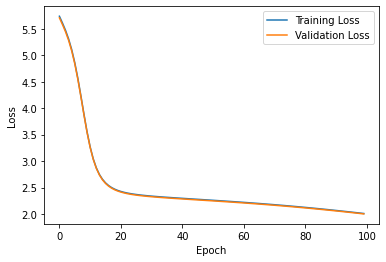

Average Reconstruction Error (Validation Set): 0.06253403640366616


In [17]:
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

#custom function for splitting data into training and and testing subsets
def train_test_split_custom(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)

    indices = np.random.permutation(X.shape[0])
    test_set_size = int(X.shape[0] * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# Load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Normalize the data
X /= 16

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split_custom(X, y, test_size=0.2, random_state=42)

# Generate an instance of NeuralNetwork class with 64x16x64 autoencoder architecture
nn_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}
]

# Hyperparameter selection
lr = 0.01
seed = 42
batch_size = 16
epochs = 100
loss_function = "mean_squared_error"

# Create NeuralNetwork instance
nn = NeuralNetwork(nn_arch, lr, seed, batch_size, epochs, loss_function)

# Train the autoencoder
train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

# Plot training and validation loss by epoch
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Quantify average reconstruction error over the validation set
y_val_pred = nn.predict(X_val)
reconstruction_error = np.mean((y_val_pred - X_val) ** 2)
print("Average Reconstruction Error (Validation Set):", reconstruction_error)

# Explanation for hyperparameter choices:

The architecture is a 64x16x64 autoencoder, where the input and output dimensions are 64, which matches the number of features in the dataset. The hidden layer has 16 neurons, which helps to learn a compressed representation of the input data.

The number of epochs is set to 100, which is a reasonable choice for this dataset. It allows the model to have enough iterations to learn the underlying patterns while not being too computationally expensive.

The batch size is set to 16, which is a common choice for mini-batch gradient descent. It strikes a balance between training speed and convergence.

The learning rate is set to 0.01, which is a common choice for gradient descent optimization. It helps the model to learn at a reasonable pace without oscillating too much or getting stuck in local minima.

Note that these hyperparameters can be further optimized through techniques like grid search, random search, or Bayesian optimization.

Also Note that I've implementated both grid search and random search based hyperparameter optimiziation below which align reasonably well with the hyperparameter values that I've chosen here 

i.e.
Grid-Search Results:
Best Model Parameters: {'architecture': [{'input_dim': 64, 'output_dim': 32, 'activation': 'relu'}, {'input_dim': 32, 'output_dim': 64, 'activation': 'sigmoid'}], 'learning_rate': 0.1, 'seed': 42, 'batch_size': 16, 'epochs': 100, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.013262797432556001

Random-Search results:
Best Model Parameters: {'architecture': [{'input_dim': 64, 'output_dim': 16, 'activation': 'relu'}, {'input_dim': 16, 'output_dim': 64, 'activation': 'sigmoid'}], 'learning_rate': 0.1, 'seed': 42, 'batch_size': 16, 'epochs': 100, 'loss_function': 'mean_squared_error'}, Reconstruction Error: 0.018418971196789927


## grid search based hyperparameter optimization

In [ ]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'hidden_neurons': [8, 16, 32]
}

# Create a ParameterGrid instance
grid = ParameterGrid(param_grid)

# Store the best model and its reconstruction error
best_model = None
best_reconstruction_error = float('inf')

# Perform Grid Search
for params in grid:
    # Update the architecture with the current hidden_neurons value
    nn_arch[0]['output_dim'] = params['hidden_neurons']
    nn_arch[1]['input_dim'] = params['hidden_neurons']

    # Create NeuralNetwork instance with the current hyperparameters
    nn = NeuralNetwork(nn_arch, params['learning_rate'], seed, params['batch_size'], epochs, loss_function)

    # Train the autoencoder
    train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

    # Compute average reconstruction error over the validation set
    y_val_pred = nn.predict(X_val)
    reconstruction_error = np.mean((y_val_pred - X_val) ** 2)

    # Update the best model if the current model has lower reconstruction error
    if reconstruction_error < best_reconstruction_error:
        best_reconstruction_error = reconstruction_error
        best_model = nn

    print(f"Parameters: {params}, Reconstruction Error: {reconstruction_error}")

print(f"Best Model Parameters: {best_model.get_hyperparameters()}, Reconstruction Error: {best_reconstruction_error}")


## Random Search based hyperparameter optimization

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

# Normalize the data
X /= 16

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fixed autoencoder architecture
nn_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "sigmoid"}
]

# Random search hyperparameter ranges
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]
epochs = [50, 100, 200]
loss_functions = ["mean_squared_error"]
n_search_iter = 10

best_reconstruction_error = float('inf')
best_model = None

for _ in range(n_search_iter):
    # Randomly select hyperparameters
    lr = random.choice(learning_rates)
    batch_size = random.choice(batch_sizes)
    epoch = random.choice(epochs)
    loss_function = random.choice(loss_functions)

    # Create a NeuralNetwork instance
    nn = NeuralNetwork(nn_arch, lr, seed, batch_size, epoch, loss_function)

    # Train the autoencoder
    train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

    # Calculate average reconstruction error over the validation set
    y_val_pred = nn.predict(X_val)
    reconstruction_error = np.mean((y_val_pred - X_val) ** 2)

    # Update best model and reconstruction error
    if reconstruction_error < best_reconstruction_error:
        best_reconstruction_error = reconstruction_error
        best_model = nn

    params = {
        'learning_rate': lr,
        'batch_size': batch_size,
        'epochs': epoch,
        'loss_function': loss_function
    }
    print(f"Parameters: {params}, Reconstruction Error: {reconstruction_error}")

print(f"Best Model Parameters: {best_model.get_hyperparameters()}, Reconstruction Error: {best_reconstruction_error}")
